# Demo: Peptide Prediction with Encrypted BigQuery ML

### Supporting research: Covid19 and beyond for vaccine candidates 

BigQuery ML enables users to create and execute machine learning models in BigQuery using SQL queries. The goal is to democratize machine learning by enabling SQL practitioners to build models using their existing tools and to increase development speed by eliminating the need for data movement.
In this tutorial, you use the sample Covid19 dataset for BigQuery.

## Objectives
In this tutorial, you will use BigQuery to explore immunological data, AutoML to automatically generate ML model for peptide binding. Also, you will leverage BQML to explore vareous ML models and perform feature engineering:
+ BigQuery `ML.CREATE` to create a classification model using the `CREATE MODEL` statement
+ The `ML.EVALUATE` function to evaluate the ML model
+ Use `ML.TRANSFORM`feature engineering functions to improve model performance
+ The `ML.PREDICT` function to make predictions using the ML model

Jupyter magics are notebook-specific shortcuts that allow you to run commands with minimal syntax. Jupyter notebooks come with many [built-in commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html). The BigQuery client library, `google-cloud-bigquery`, provides a cell magic, `%%bigquery`. The `%%bigquery` magic runs a SQL query and returns the results as a pandas `DataFrame`.

## Step 1: Explore Peptidic Epitope Data
For our coronavirus subset of data, let's examine data first:
+ Following query shows information about antigen.
+ Observe specific antigen that might of more interest to our study for coronavirus.
+ Can you find it?


In [1]:
# Read GCP project id from env.
shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
GCP_PROJECT_ID=shell_output[0]
print("GCP project ID:" + GCP_PROJECT_ID)

GCP project ID:covid-19-271622


In [2]:
# Define project__id variable
project_id = 'covid-19-271622'

In [3]:
%%bigquery --project $project_id
SELECT * 
FROM `corona.antigen`
LIMIT 10

,Antigen_Name,Organism_Name,__Epitopes,__Assays,__References
0,Nucleoprotein,Avian coronavirus,1,2,1
1,Other Avian coronavirus protein,Avian coronavirus,1,1,1
2,Replicase polyprotein 1ab,Betacoronavirus 1,1,1,1
3,Non-structural protein 2a,Betacoronavirus 1,1,5,1
4,Replicase polyprotein 1ab,Alphacoronavirus 1,1,1,1
5,Nucleoprotein,Alphacoronavirus 1,1,1,1
6,Envelope small membrane protein,Murine coronavirus,16,32,1
7,Membrane protein,Murine coronavirus,44,91,1
8,Spike glycoprotein,Human coronavirus 229E,3,6,1
9,nucleoprotein,Middle East respiratory syndrome-related coron...,94,94,1


Visually inspect number of epitopes by antigen name in our dataset.

In [4]:
%%bigquery epitopes --project $project_id
SELECT
 Antigen_Name,
 sum(__Epitopes) AS epitope
FROM `corona.antigen`
GROUP BY Antigen_Name
ORDER BY epitope DESC

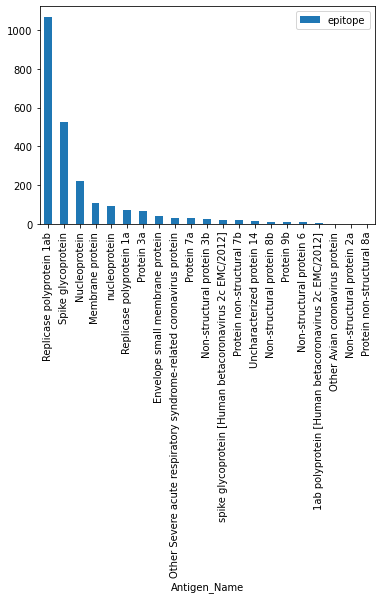

In [5]:
epitopes.plot(kind='bar', x='Antigen_Name', y='epitope');

In [6]:
# Following query shows epitope detail for those linear peptides whose parent protein
# came from Spike glycoprotein, which is our interests to investigate for possible antigen
# to protect against coronavirus


In [7]:
%%bigquery --project $project_id
SELECT Epitope_ID, Object_Type, Description, Starting_Position,
            Ending_Position, Antigen_Name,Parent_Protein, Organism_Name
FROM `corona.epitope` 
WHERE Parent_Protein = 'Spike glycoprotein'
LIMIT 10

,Epitope_ID,Object_Type,Description,Starting_Position,Ending_Position,Antigen_Name,Parent_Protein,Organism_Name
0,2801,Linear peptide,ALNTLVKQL,940,948,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
1,12967,Linear peptide,ELCDNPFFA,131,139,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
2,26710,Linear peptide,IITTDNTFV,1096,1104,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
3,27146,Linear peptide,ILLCCMTSC,1214,1222,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
4,27241,Linear peptide,ILPDPLKPT,787,795,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
5,32036,Linear peptide,KLNDLCFSNV,373,382,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
6,32068,Linear peptide,KLPDDFMGC,411,419,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
7,32069,Linear peptide,KLPDDFMGCV,411,420,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
8,36724,Linear peptide,LITGRLQSL,978,986,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01
9,37544,Linear peptide,LLLQYGSFC,734,742,Spike glycoprotein precursor,Spike glycoprotein,SARS coronavirus BJ01


As you can see from the resulting query, we have a set of peptides generated from parent antigen protein. Now, we need to identify how these peptides bind with HLA molecule.

Following query shows HLA-peptide binding affinity information. The goal is to leverage machine learning models to predict binding affinity for many different and new peptides with HLA MHC Class-I molecules so that testing for vaccine candidates can be prioritized to accelerate solutions.


In [8]:
%%bigquery --project $project_id
SELECT Reference_ID, Description, Allele_Name,MHC_allele_class, Assay_Group,
       Qualitative_Measure, Quantitative_measurement 
FROM `corona.mhc_ligand`
WHERE Epitope_ID = 12967 


,Reference_ID,Description,Allele_Name,MHC_allele_class,Assay_Group,Qualitative_Measure,Quantitative_measurement
0,642,ELCDNPFFA,HLA-A*02:01,I,qualitative binding,Positive,0.4


In our dataset there are multiple of alleles and, for each allele we have epitope binding affinity measure. Lete inspect how epitopes and allele bindings are distributed in the dataset. This is one way to short list possible allele to consider for peptide binding research.

We will use dataframe to hold query result to build our visualization.

In [9]:
from google.cloud import bigquery
client = bigquery.Client()

In [10]:
sql = """
SELECT Qualitative_Measure, 
       Allele_Name, 
       count(1) as count 
FROM `corona.mhc_ligand`
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Allele_Name,count
0,Negative,HLA-A*01:01,443
1,Negative,HLA-A*24:02,438
2,Positive-High,HLA-A*02:01,406
3,Negative,HLA-A*26:01,393
4,Positive-High,HLA-A*02:02,392


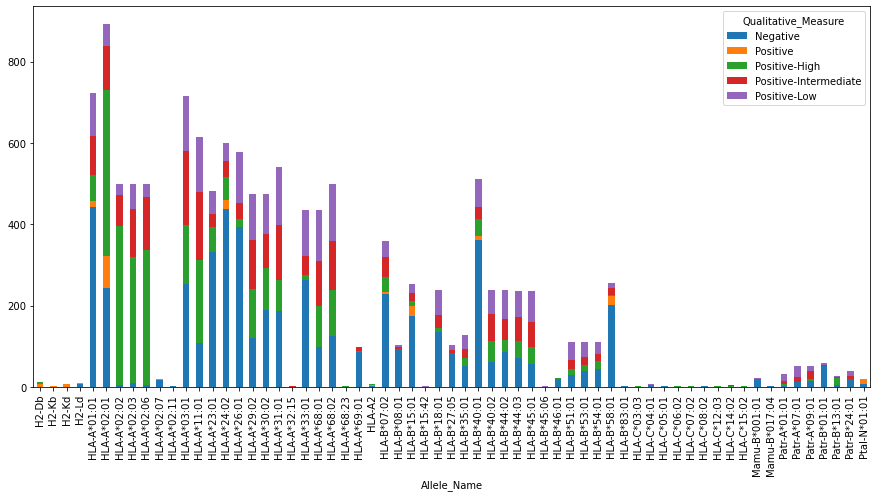

In [11]:
pivot_table = df.pivot(index='Allele_Name', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

Based on data insepction, it seems like for coronavirus data set, HLA-A-01-01, HLA-A-02-01, HLA-A-02-02, HLA-A-02-03 and HLA-A-020-06 alleles are most likely candidates for MHC-I molecules.

It is important to narrow down focus peptides and HLA binding to speed up testing on most probable vaccine candidate. Lets identify set of peptides that binds well with HLA, you can further narrow it to specific HLA as well. Following qury execution suggest that peptides with length of 9 and 10 are having better binding affinity. We should focus our research on those for now. Of course, more factors, features as well as 3D structure of aplha/beta components of HLA+Peptide bindings are useful for more complex modeling. 

In [12]:
sql = """
SELECT Qualitative_Measure, 
       length(Description) as Peptide_Length, 
       count(1) as count 
FROM `corona.mhc_ligand`
GROUP BY  1,2
ORDER BY 3 DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,Qualitative_Measure,Peptide_Length,count
0,Negative,9,3974
1,Positive-High,9,2008
2,Positive-Low,9,1275
3,Positive-Intermediate,9,1260
4,Negative,10,1196


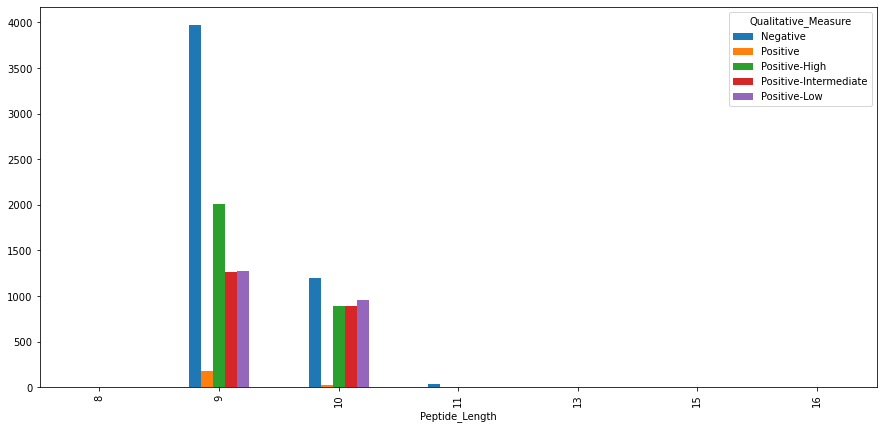

In [13]:
pivot_table = df.pivot(index='Peptide_Length', columns='Qualitative_Measure', values='count')
pivot_table.plot(kind='bar', stacked=False, figsize=(15, 7));

Lets build feature table that translate Peotide Amino Acid sqquence into positioning columns. Explore amino acid properties table, it is prepared with allocation of acid sequnece number as well as additional properites that you can leverage for cross feature engineering.

In [14]:
%%bigquery --project $project_id
SELECT *
FROM `hla_peptide_generic.amino_acid`

,a_index,amino_acid,abbriviation,short_abrv,formula,polarity,hydropathy_index,molecular_weight,isoelectric_point
0,21,Any amino acid,Xaa,X,None,None,0.00,0.00,0.00
1,1,Alanine,Ala,A,C3H7N1O2,Uncharged,0.62,89.09,6.00
2,8,Glycine,Gly,G,C2H5N1O2,Uncharged,0.48,75.07,5.97
3,10,Isoleucine,Ile,I,C6H13N1O2,Uncharged,1.40,131.17,5.94
4,11,Leucine,Leu,L,C6H13N1O2,Uncharged,1.10,131.17,5.98
5,14,Phenylalanine,Phe,F,C9H11N1O2,Uncharged,1.20,165.19,5.48
6,15,Proline,Pro,P,C5H9N1O2,Uncharged,0.12,115.13,6.30
7,20,Valine,Val,V,C5H11N1O2,Uncharged,1.10,117.15,5.96
8,3,Asparagine,Asn,N,C4H8N2O3,Non-Polarity,-0.78,132.12,5.41
9,5,Cysteine,Cys,C,C3H7N1O2S1,Non-Polarity,0.29,121.16,5.02


We will examine pre-built feature table called mhc_qual_feature which has column presentation of 9 and 10 letter (MER) peptide sequence which are most suitable for MHC-1 binding. Table also contains qualitative measure and quantitative measure.

+ Peptides are transformed into column A1 to A10 based on amino acid position value in a chain
+ result_score is quantitative measure: lower the number, higher binding affinity
+ result columns is binary classification based on 5 class result_quality score

In [15]:
%%bigquery --project $project_id
SELECT *
FROM `corona.mhc_qual_feature`
LIMIT 10

,ligand_id,peptide,result_type,result,Allele,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,result_score,result_quality
0,1717014,ILLNKHID,Positive-Low,0,HLA-A*02:01,0,0,0,0,0,0,0,0,0,0,4000.0,1
1,1025027,AACAMLLVK,Negative,0,HLA-A*68:01,1,1,5,1,13,11,11,20,12,0,16800.0,0
2,1025025,AACAMLLVK,Negative,0,HLA-A*31:01,1,1,5,1,13,11,11,20,12,0,10600.0,0
3,1025026,AACAMLLVK,Negative,0,HLA-A*33:01,1,1,5,1,13,11,11,20,12,0,77700.0,0
4,1025023,AACAMLLVK,Positive-Low,0,HLA-A*03:01,1,1,5,1,13,11,11,20,12,0,638.0,1
5,1025197,AAISDYDYY,Positive-Low,0,HLA-A*68:01,1,1,10,16,4,19,4,19,19,0,4810.0,1
6,1025194,AAISDYDYY,Positive-Low,0,HLA-A*11:01,1,1,10,16,4,19,4,19,19,0,1100.0,1
7,1025195,AAISDYDYY,Negative,0,HLA-A*31:01,1,1,10,16,4,19,4,19,19,0,17500.0,0
8,1025193,AAISDYDYY,Positive-Low,0,HLA-A*03:01,1,1,10,16,4,19,4,19,19,0,698.0,1
9,1025196,AAISDYDYY,Negative,0,HLA-A*33:01,1,1,10,16,4,19,4,19,19,0,77700.0,0


## Encryption Demo 
+ Data Set

In [114]:
%%bigquery --project $project_id
SELECT *
FROM `corona.mhc_qual_feature`
LIMIT 10

,ligand_id,peptide,result_type,result,Allele,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,result_score,result_quality
0,1717014,ILLNKHID,Positive-Low,0,HLA-A*02:01,0,0,0,0,0,0,0,0,0,0,4000.0,1
1,1025027,AACAMLLVK,Negative,0,HLA-A*68:01,1,1,5,1,13,11,11,20,12,0,16800.0,0
2,1025025,AACAMLLVK,Negative,0,HLA-A*31:01,1,1,5,1,13,11,11,20,12,0,10600.0,0
3,1025026,AACAMLLVK,Negative,0,HLA-A*33:01,1,1,5,1,13,11,11,20,12,0,77700.0,0
4,1025023,AACAMLLVK,Positive-Low,0,HLA-A*03:01,1,1,5,1,13,11,11,20,12,0,638.0,1
5,1025197,AAISDYDYY,Positive-Low,0,HLA-A*68:01,1,1,10,16,4,19,4,19,19,0,4810.0,1
6,1025194,AAISDYDYY,Positive-Low,0,HLA-A*11:01,1,1,10,16,4,19,4,19,19,0,1100.0,1
7,1025195,AAISDYDYY,Negative,0,HLA-A*31:01,1,1,10,16,4,19,4,19,19,0,17500.0,0
8,1025193,AAISDYDYY,Positive-Low,0,HLA-A*03:01,1,1,10,16,4,19,4,19,19,0,698.0,1
9,1025196,AAISDYDYY,Negative,0,HLA-A*33:01,1,1,10,16,4,19,4,19,19,0,77700.0,0


## Create keys for each record

In [115]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE `encryption.encryption_key` 
(
    ligand_id int64,
    keyset BYTES
) AS  
SELECT ligand_id, KEYS.NEW_KEYSET('AEAD_AES_GCM_256') AS keyset 
FROM `corona.mhc_qual_feature`


""


In [116]:
%%bigquery --project $project_id
SELECT * FROM `encryption.encryption_key`
LIMIT 5

,ligand_id,keyset
0,1023243,b'\x08\xf6\x8f\x9c\xfc\x05\x12d\nX\n0type.goog...
1,20745,b'\x08\xfd\xeb\x97\x02\x12c\nX\n0type.googleap...
2,1023825,b'\x08\xf2\xd9\xb6\xbb\x04\x12d\nX\n0type.goog...
3,2148011,b'\x08\x86\xae\xf8\xc5\x0b\x12d\nX\n0type.goog...
4,1025202,b'\x08\xff\x83\xd6\xce\x0f\x12d\nX\n0type.goog...


## Encrypt A1 and A2

In [117]:
%%bigquery --project $project_id
CREATE OR REPLACE TABLE `corona.mhc_qual_feature_encryption` 
AS SELECT ligand_id, peptide, result_quality, Allele, 
AEAD.ENCRYPT((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
CAST(A1 AS STRING), CAST(mhc.ligand_id AS STRING)) A1_encrypted, 
AEAD.ENCRYPT((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
CAST(A2 AS STRING), CAST(mhc.ligand_id AS STRING)) A2_encrypted, 
A3, A4, A5, A6, A7, A8, A9, A10 
FROM `corona.mhc_qual_feature` as mhc

""


## Query encrypted data

In [119]:
%%bigquery --project $project_id
SELECT * FROM `corona.mhc_qual_feature_encryption`
LIMIT 5

,ligand_id,peptide,result_quality,Allele,A1_encrypted,A2_encrypted,A3,A4,A5,A6,A7,A8,A9,A10
0,1717014,ILLNKHID,1,HLA-A*02:01,b'\x01\\\xd2(\xc0\x02:\xd7j\xb5\xea\x0c\xe7\xe...,b'\x01\\\xd2(\xc0\xc1c\xef\xa6\xa5EA\xfd\x8f9f...,0,0,0,0,0,0,0,0
1,2104726,RCQIFANI,4,H2-Kb,b'\x01\xd9\xb3\xe7\xb4aKj\xbc\x1bE\x14\x90\x91...,"b'\x01\xd9\xb3\xe7\xb4\x89\xa7$\xdc%i""h\x1f\xd...",0,0,0,0,0,0,0,0
2,2104720,RCQIFANI,4,H2-Kb,b'\x01A4\x08JV\xc6\xae\x91E\x980\xd8\x13QG\x9c...,"b'\x01A4\x08J\x885""o\\V\x90\xf2\xa1yS\xfa""\x8d...",0,0,0,0,0,0,0,0
3,2007554,ALALLLLDRLN,0,HLA-B*46:01,b'\x01\x92\xf5z\x1d\xba\x96xO\x13H^h\n\xb1\x8c...,b'\x01\x92\xf5z\x1d\x94\xf9@\xf9(\x9c\xbf\xc5\...,0,0,0,0,0,0,0,0
4,2007552,ALALLLLDRLN,0,HLA-A*02:07,b'\x01\x08g\xf9\x91\xf1\x10\xc5\x8a#K\xfbZT\x8...,"b""\x01\x08g\xf9\x91,\xea\xb89\\\x01+\xde>\x1eY...",0,0,0,0,0,0,0,0


## Decrypt data

In [120]:
%%bigquery --project $project_id 
SELECT ligand_id, peptide, result_quality, Allele, 
AEAD.DECRYPT_STRING((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
mhc.A1_encrypted, CAST(mhc.ligand_id AS STRING)) A1_decrypted, 
AEAD.DECRYPT_STRING((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
mhc.A2_encrypted, CAST(mhc.ligand_id AS STRING)) A2_decrypted, 
A3, A4, A5, A6, A7, A8, A9, A10 
FROM `corona.mhc_qual_feature_encryption` as mhc
WHERE ligand_id = 1717014 OR ligand_id = 1025027

,ligand_id,peptide,result_quality,Allele,A1_decrypted,A2_decrypted,A3,A4,A5,A6,A7,A8,A9,A10
0,1717014,ILLNKHID,1,HLA-A*02:01,0,0,0,0,0,0,0,0,0,0
1,1025027,AACAMLLVK,0,HLA-A*68:01,1,1,5,1,13,11,11,20,12,0


## Compare with Original

In [107]:
%%bigquery --project $project_id 
SELECT * FROM `corona.mhc_qual_feature` as mhc
WHERE ligand_id = 1717014 OR ligand_id = 1025027

,ligand_id,peptide,result_type,result,Allele,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,result_score,result_quality
0,1717014,ILLNKHID,Positive-Low,0,HLA-A*02:01,0,0,0,0,0,0,0,0,0,0,4000.0,1
1,1025027,AACAMLLVK,Negative,0,HLA-A*68:01,1,1,5,1,13,11,11,20,12,0,16800.0,0


## Step 3: Build You First Classification Model with BQML
Building ML models with BigQuery is as simple as writing SQL statements; makes ML modeling accessible to even SQL developers and analysts. We will create a simple classification model to predict for a given peptide if there is strong binding affinity with certain HLA Allele.

Following statement creates a classification model using logistic regression. We are selecting feature columns of Allele and amino acid positioning within a peptide to classify if a peptide is a good candidate for vaccine testing.

+ Note: we are filtering data for peptides with length of 9 or 10 mers only. Also, since we run multiple samples, we are randomizing samples by 80% of data for learning.


In [108]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq1`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality']
)
AS
SELECT
 result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10
 FROM
  `corona.mhc_qual_feature`
 WHERE length(peptide) IN (9,10)
 AND rand() < 0.8

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_bq1`) appears in the navigation panel of the
BigQuery web UI. Because the query uses a `CREATE MODEL` statement to create a
table, you do not see query results. The output is an empty `DataFrame`.

In [24]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq1_encrypt`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality'],
kms_key_name='projects/covid-19-271622/locations/us/keyRings/encrypt-corona/cryptoKeys/encrypt_corona_key'
)
AS
SELECT
 result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10
 FROM
  `corona.mhc_qual_feature`
 WHERE length(peptide) IN (9,10)
 AND rand() < 0.8

""


In [121]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq1_encrypt2`
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality'],
kms_key_name='projects/covid-19-271622/locations/us/keyRings/encrypt-corona/cryptoKeys/encrypt_corona_key'
)
AS
SELECT result_quality, Allele, 
AEAD.DECRYPT_STRING((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
mhc.A1_encrypted, CAST(mhc.ligand_id AS STRING)) A1_decrypted, 
AEAD.DECRYPT_STRING((SELECT keyset FROM `encryption.encryption_key` as keys where keys.ligand_id=mhc.ligand_id), 
mhc.A2_encrypted, CAST(mhc.ligand_id AS STRING)) A2_decrypted, 
A3, A4, A5, A6, A7, A8, A9, A10 
FROM `corona.mhc_qual_feature_encryption` as mhc
 WHERE length(peptide) IN (9,10)
 AND rand() < 0.8
 

""


## Get training statistics

To see the results of the model training, you can use the
[`ML.TRAINING_INFO`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train)
function, or you can view the statistics in the BigQuery web UI.
In this tutorial, you use the `ML.TRAINING_INFO` function.

A machine learning algorithm builds a model by examining many examples and
attempting to find a model that minimizes loss. This process is called empirical
risk minimization.

Loss is the penalty for a bad prediction &mdash; a number indicating
how bad the model's prediction was on a single example. If the model's
prediction is perfect, the loss is zero; otherwise, the loss is greater. The
goal of training a model is to find a set of weights that have low
loss, on average, across all examples.

To see the model training statistics that were generated when you ran the
`CREATE MODEL` query:

In [122]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq1_encrypt2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.223332,0.229783,3.2,6608
1,0,4,0.225184,0.229907,3.2,7037
2,0,3,0.233764,0.237642,1.6,6805
3,0,2,0.250820,0.253698,0.8,10869
4,0,1,0.276739,0.278299,0.4,6344
5,0,0,0.303230,0.303806,0.2,12155


## Compare with none encrypted 

In [123]:
%%bigquery --project $project_id
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.226544,0.232892,3.2,5939
1,0,5,0.227418,0.234066,6.4,3994
2,0,4,0.231989,0.236936,3.2,5383
3,0,3,0.242992,0.245705,1.6,4974
4,0,2,0.265568,0.267086,0.8,4471
5,0,1,0.291567,0.292312,0.4,4952
6,0,0,0.310592,0.310859,0.2,3214


In [112]:
%%bigquery loss_curve --project $project_id
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq1`)
ORDER BY iteration ASC

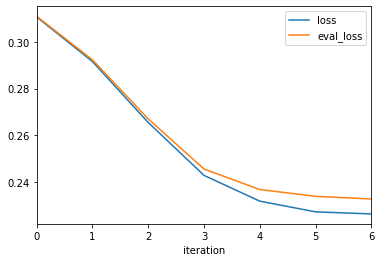

In [113]:
loss_curve.plot(x='iteration');

The `loss` column represents the loss metric calculated after the given iteration
on the training dataset. Since you performed a logistic regression, this column
is the [log loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression).
The `eval_loss` column is the same loss metric calculated on
the holdout dataset (data that is held back from training to validate the model).

For more details on the `ML.TRAINING_INFO` function, see the
[BigQuery ML syntax reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-train).

## Evaluate your model

After creating your model, you evaluate the performance of the classifier using
the [`ML.EVALUATE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate)
function. You can also use the [`ML.ROC_CURVE`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc)
function for logistic regression specific metrics.

A classifier is one of a set of enumerated target values for a label. For
example, in this tutorial you are using a binary classification model that
detects transactions. The two classes are the values in the `label` column:
`0` (no transactions) and not `1` (transaction made).

To run the `ML.EVALUATE` query that evaluates the model:

In [103]:
%%bigquery --project $project_id
SELECT
  *
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq1`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.520667,0.338201,0.516683,0.327543,1.60369,0.766784


In [104]:
%%bigquery --project $project_id
SELECT roc_auc,
       CASE WHEN roc_auc > .85 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq1`)

,roc_auc,model_quality
0,0.766784,fair


## Step 4: Improve Model Performance with Feature Engineering
BigQuery offers many [transform / preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) functions for feature engineering on data. Advantage of transform functions is that once you build a model with preprocessing as part of model definition, prediction data does not need to be prepared as the model will apply transformation for the input. Lets see one example of a transform feature and rebuild our model to check if we get better model performance.

Following statement will create another classification model with preprocessing of the result score to normalize its deviation with respect to min-max value of an attribute.


In [97]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `corona.Classification_model_bq2`
TRANSFORM (result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, 
           ML.MIN_MAX_SCALER(result_score) OVER() AS rs
)
OPTIONS
(
model_type='logistic_reg',
input_label_cols=['result_quality']
)
AS
SELECT result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, result_score
FROM `corona.mhc_qual_feature`
WHERE length(peptide) IN (9,10)
AND rand() < 0.8

""


The query takes several minutes to complete. After the first iteration is
complete, your model (`Classification_model_bq2`) appears in the navigation panel of the
BigQuery web UI. The output is an empty `DataFrame`.

Check model performance after feature engineering, run the `ML.EVALUATE` query that evaluates the model:

In [106]:
%%bigquery loss_curve2 --project $project_id
SELECT
  iteration, loss, eval_loss
FROM
  ML.TRAINING_INFO(MODEL `corona.Classification_model_bq2`)
ORDER BY iteration ASC

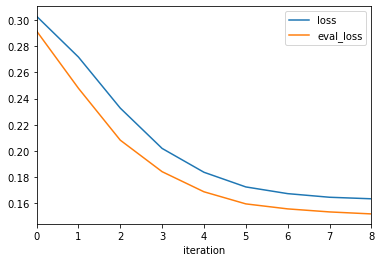

In [107]:
loss_curve2.plot(x='iteration');

In [96]:
%%bigquery --project $project_id
SELECT roc_auc,
       CASE WHEN roc_auc > .85 THEN 'good'
            WHEN roc_auc > .7 THEN 'fair'
            WHEN roc_auc > .5 THEN 'not great'
            ELSE 'poor' END AS model_quality
FROM ML.EVALUATE(MODEL `corona.Classification_model_bq2`)

,roc_auc,model_quality
0,0.882205,good


As you can see model performance has improved!

With BigQuery you can take advantage of an already available highly powerful computer data processing and analysis platform to build a machine learning model, without moving your data! You can learn more about BQML here. For our data set, you can build a DNN_Regression model to predict the result_score for a peptide HLA binding. Try that as a practice!

## Step 5: Run Prediction on BQML Model
Now that you have evaluated your model, the next step is to use it to predict
outcomes. 

To run the query that uses the model to predict the number of transactions:
Following example demonstrate leveraging BQ model for prediction. Optionally, you can export model and publish it on to Google AI Platform for serving prediction.


In [97]:
%%bigquery --project $project_id
SELECT
  predicted_result_quality, predicted_result_quality_probs, result_quality as original_result, result_score
FROM ML.PREDICT(MODEL `corona.Classification_model_bq2`, (
  SELECT result_quality, Allele, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, result_score
  FROM `corona.mhc_qual_feature`
  WHERE length(peptide) IN (9,10)
  AND rand() < 0.0009))

,predicted_result_quality,predicted_result_quality_probs,original_result,result_score
0,3,"[{'label': 3, 'prob': 0.7176001894919181}, {'l...",2,143.0
1,3,"[{'label': 3, 'prob': 0.37093010570816276}, {'...",0,7710.0
2,1,"[{'label': 1, 'prob': 0.3078493730337912}, {'l...",2,378.0
3,1,"[{'label': 1, 'prob': 0.5462742398553166}, {'l...",2,151.2
4,0,"[{'label': 0, 'prob': 0.997928508608279}, {'la...",0,100000.0
5,0,"[{'label': 0, 'prob': 0.994754089591697}, {'la...",0,100000.0
6,0,"[{'label': 0, 'prob': 0.9982437745997961}, {'l...",0,100000.0
7,1,"[{'label': 1, 'prob': 0.33475287661737385}, {'...",2,223.0
8,2,"[{'label': 2, 'prob': 0.3639550434774355}, {'l...",3,9.8
9,1,"[{'label': 1, 'prob': 0.2895531031441645}, {'l...",3,19.2


The result shows predicted quality class with confidence. You can compare that with original result. Next step is to operationalize ML pipeline so that you can efficiently perform data updates and model updates. Check out AI Pipeline example for peptide prediction to learn more!